<a href="https://colab.research.google.com/github/victorgsosa/GANMarketing/blob/main/COCO_CGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [71]:
from __future__ import print_function, division

import tensorflow as tf
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
import tensorflow_datasets as tfds


from tensorflow import keras
from tensorflow.keras.layers import Layer, Add, Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, BatchNormalization, ReLU, LeakyReLU, Dropout, ZeroPadding2D, UpSampling2D, Concatenate
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam


In [47]:
(train_dataset, val_dataset), dataset_info = tfds.load(
    "coco/2017", split=["train", "validation"], with_info=True, data_dir="data"
)

In [48]:
print(dataset_info)

tfds.core.DatasetInfo(
    name='coco',
    version=1.1.0,
    description='COCO is a large-scale object detection, segmentation, and
captioning dataset. This version contains images, bounding boxes "
and labels for the 2017 version.
Note:
 * Some images from the train and validation sets don't have annotations.
 * Coco 2014 and 2017 uses the same images, but different train/val/test splits
 * The test split don't have any annotations (only images).
 * Coco defines 91 classes but the data only uses 80 classes.
 * Panotptic annotations defines defines 200 classes but only uses 133.',
    homepage='http://cocodataset.org/#home',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'image/id': tf.int64,
        'objects': Sequence({
            'area': tf.int64,
            'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
            'id': tf.int64,
            'is_crowd': tf.bool,
 

In [49]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    plt.figure(figsize=(n_cols*4, n_rows*3))
    for index, example in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        image = example["image"]
        plt.title(image.shape)
        plt.imshow(image)
        plt.axis("off")

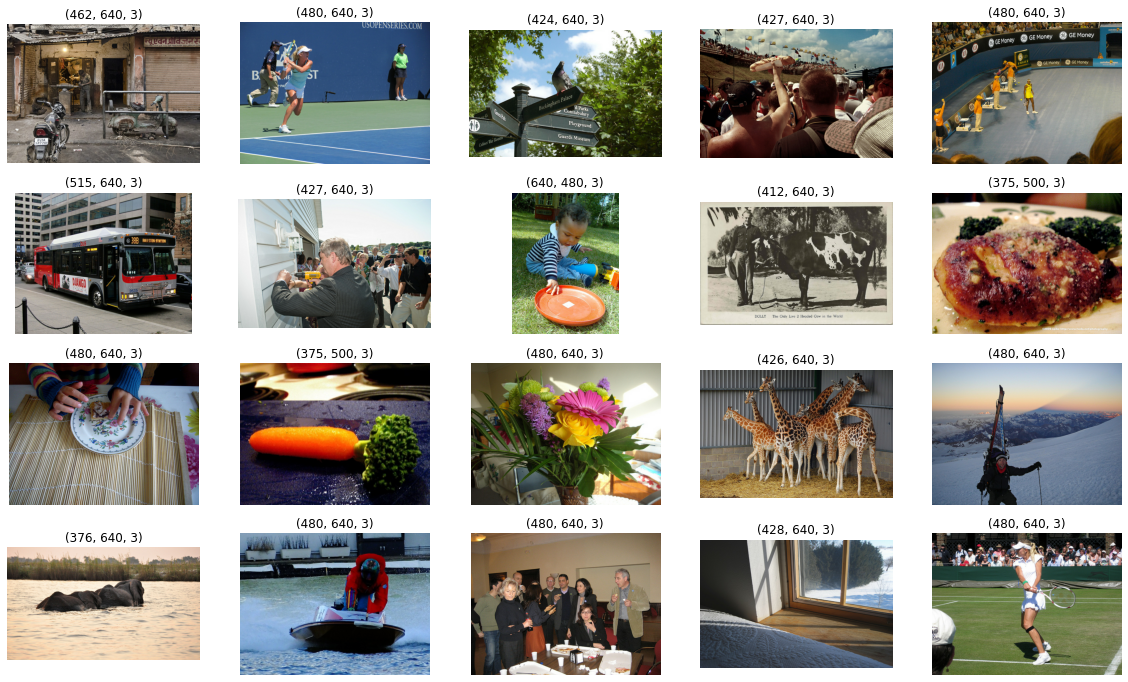

In [50]:
samples=20
ds = train_dataset.take(samples)  # Only take a single example
plot_multiple_images(ds, n_cols=5)

In [65]:
batch_size = 1
size = (512, 512, 3)
classes = dataset_info.features['objects']['label'].names
num_classes = dataset_info.features['objects']['label'].num_classes

In [52]:

def preprocess_data(sample):
    """Applies preprocessing step to a single sample

    Arguments:
      sample: A dict representing a single training sample.

    Returns:
      image: Resized and padded image with random horizontal flipping applied.
      bbox: Bounding boxes with the shape `(num_objects, 4)` where each box is
        of the format `[x, y, width, height]`.
      class_id: An tensor representing the class id of the objects, having
        shape `(num_objects,)`.
    """
    image = sample["image"]
    class_ids = tf.cast(sample["objects"]["label"], dtype=tf.int32)
    class_ids = tf.math.reduce_sum(tf.one_hot(class_ids, num_classes), 0)
    image = keras.preprocessing.image.smart_resize(image, (size[0], size[1]))
    image = tf.image.per_image_standardization(image)

    return image, class_ids

In [53]:
autotune = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.map(preprocess_data, num_parallel_calls=autotune)
print(train_dataset)

<ParallelMapDataset shapes: ((512, 512, None), (80,)), types: (tf.float32, tf.float32)>


In [54]:
class FeaturePyramid(Layer):
    """Builds the Feature Pyramid with the feature maps from the backbone.

    Attributes:
      num_classes: Number of classes in the dataset.
      backbone: The backbone to build the feature pyramid from.
        Currently supports ResNet50 only.
    """

    def __init__(self, backbone=None, **kwargs):
        super(FeaturePyramid, self).__init__(name="FeaturePyramid", **kwargs)
        self.backbone = backbone if backbone else get_backbone()
        self.conv_c3_1x1 = keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c4_1x1 = keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c5_1x1 = keras.layers.Conv2D(256, 1, 1, "same")
        self.conv_c3_3x3 = keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c4_3x3 = keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c5_3x3 = keras.layers.Conv2D(256, 3, 1, "same")
        self.conv_c6_3x3 = keras.layers.Conv2D(256, 3, 2, "same")
        self.conv_c7_3x3 = keras.layers.Conv2D(256, 3, 2, "same")
        self.upsample_2x = keras.layers.UpSampling2D(2)

    def call(self, images, training=False):
        c3_output, c4_output, c5_output = self.backbone(images, training=training)
        p3_output = self.conv_c3_1x1(c3_output)
        p4_output = self.conv_c4_1x1(c4_output)
        p5_output = self.conv_c5_1x1(c5_output)
        p4_output = p4_output + self.upsample_2x(p5_output)
        p3_output = p3_output + self.upsample_2x(p4_output)
        p3_output = self.conv_c3_3x3(p3_output)
        p4_output = self.conv_c4_3x3(p4_output)
        p5_output = self.conv_c5_3x3(p5_output)
        p6_output = self.conv_c6_3x3(c5_output)
        p7_output = self.conv_c7_3x3(tf.nn.relu(p6_output))
        return p3_output, p4_output, p5_output, p6_output, p7_output


def build_head(output_filters, bias_init):
    """Builds the class/box predictions head.

    Arguments:
      output_filters: Number of convolution filters in the final layer.
      bias_init: Bias Initializer for the final convolution layer.

    Returns:
      A keras sequential model representing either the classification
        or the box regression head depending on `output_filters`.
    """
    input = keras.Input(shape=[None, None, 256])
    x = input
    kernel_init = tf.initializers.RandomNormal(0.0, 0.01)
    x = Conv2D(256, 3, padding="same", kernel_initializer=kernel_init)(x)
    x = ReLU()(x)
    x = Conv2D(256, 3, padding="same", kernel_initializer=kernel_init)(x)
    x = ReLU()(x)
    x = Conv2D(256, 3, padding="same", kernel_initializer=kernel_init)(x)
    x = ReLU()(x)
    x = Conv2D(256, 3, padding="same", kernel_initializer=kernel_init)(x)
    x = ReLU()(x)
    x = Conv2D(256, 3, padding="same", kernel_initializer=kernel_init)(x)
    x = ReLU()(x)
    
    output = keras.layers.Conv2D(
            output_filters,
            3,
            1,
            padding="same",
            kernel_initializer=kernel_init,
            bias_initializer=bias_init,
        )(x)
    return Model(input, output)

class RetinaNetClassificationLoss(tf.losses.Loss):
    """Implements Focal loss"""

    def __init__(self, alpha, gamma):
        super(RetinaNetClassificationLoss, self).__init__(
            reduction="none", name="RetinaNetClassificationLoss"
        )
        self._alpha = alpha
        self._gamma = gamma

    def call(self, y_true, y_pred):
        cross_entropy = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=y_true, logits=y_pred
        )
        probs = tf.nn.sigmoid(y_pred)
        alpha = tf.where(tf.equal(y_true, 1.0), self._alpha, (1.0 - self._alpha))
        pt = tf.where(tf.equal(y_true, 1.0), probs, 1 - probs)
        loss = alpha * tf.pow(1.0 - pt, self._gamma) * cross_entropy
        return tf.reduce_sum(loss, axis=-1)

class RetinaNetLoss(tf.losses.Loss):
    """Wrapper to combine both the losses"""

    def __init__(self, num_classes=80, alpha=0.25, gamma=2.0, delta=1.0):
        super(RetinaNetLoss, self).__init__(reduction="auto", name="RetinaNetLoss")
        self._clf_loss = RetinaNetClassificationLoss(alpha, gamma)
        self._num_classes = num_classes

    def call(self, y_true, y_pred):
        y_pred = tf.cast(y_pred, dtype=tf.float32)
        cls_labels = tf.one_hot(
            tf.cast(y_true[:, :, 4], dtype=tf.int32),
            depth=self._num_classes,
            dtype=tf.float32,
        )
        cls_predictions = y_pred[:, :, 4:]
        positive_mask = tf.cast(tf.greater(y_true[:, :, 4], -1.0), dtype=tf.float32)
        ignore_mask = tf.cast(tf.equal(y_true[:, :, 4], -2.0), dtype=tf.float32)
        clf_loss = self._clf_loss(cls_labels, cls_predictions)
        clf_loss = tf.where(tf.equal(ignore_mask, 1.0), 0.0, clf_loss)
        normalizer = tf.reduce_sum(positive_mask, axis=-1)
        clf_loss = tf.math.divide_no_nan(tf.reduce_sum(clf_loss, axis=-1), normalizer)
        return clf_loss

In [74]:
class CGAN():
    def __init__(self
        , img_shape
        , num_classes
        , discriminator_conv_filters
        , discriminator_conv_kernel_size
        , discriminator_conv_strides
        , discriminator_batch_norm_momentum
        , discriminator_activation
        , discriminator_dropout_rate
        , discriminator_learning_rate
        , generator_initial_dense_layer_size
        , generator_upsample
        , generator_conv_filters
        , generator_conv_kernel_size
        , generator_conv_strides
        , generator_batch_norm_momentum
        , generator_activation
        , generator_dropout_rate
        , generator_learning_rate
        , optimiser
        , latent_dim=100):
        self.img_shape = img_shape
        self.num_classes = num_classes
        self.latent_dim = latent_dim

        self.discriminator_conv_filters = discriminator_conv_filters
        self.discriminator_conv_kernel_size = discriminator_conv_kernel_size
        self.discriminator_conv_strides = discriminator_conv_strides
        self.discriminator_batch_norm_momentum = discriminator_batch_norm_momentum
        self.discriminator_activation = discriminator_activation
        self.discriminator_dropout_rate = discriminator_dropout_rate
        self.discriminator_learning_rate = discriminator_learning_rate

        self.generator_initial_dense_layer_size = generator_initial_dense_layer_size
        self.generator_upsample = generator_upsample
        self.generator_conv_filters = generator_conv_filters
        self.generator_conv_kernel_size = generator_conv_kernel_size
        self.generator_conv_strides = generator_conv_strides
        self.generator_batch_norm_momentum = generator_batch_norm_momentum
        self.generator_activation = generator_activation
        self.generator_dropout_rate = generator_dropout_rate
        self.generator_learning_rate = generator_learning_rate
        
        self.optimiser = optimiser

        self.n_layers_discriminator = len(discriminator_conv_filters)
        self.n_layers_generator = len(generator_conv_filters)

        self.weight_init = None

        self.d_losses = []
        self.g_losses = []

        self.epoch = 0

        self._build_discriminator()
        self._build_generator()
        self._build_retina()

        self._build_adversarial()
    

    def _build_generator(self):
        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(self.num_classes,))

        x1 = noise
        x2 = label 

        x1 = Dense(np.prod(self.generator_initial_dense_layer_size), kernel_initializer = self.weight_init)(x1)
        x2 = Dense(np.prod(self.generator_initial_dense_layer_size), kernel_initializer = self.weight_init)(x2)
        if self.generator_batch_norm_momentum:
            x1 = BatchNormalization(momentum = self.generator_batch_norm_momentum)(x1)
            x2 = BatchNormalization(momentum = self.generator_batch_norm_momentum)(x2)
        
        x1 = self.get_activation(self.generator_activation)(x1)
        x2 = self.get_activation(self.generator_activation)(x2)

        x = Add()([x1, x2])

        x = Reshape(self.generator_initial_dense_layer_size)(x)

        if self.generator_dropout_rate:
            x = Dropout(rate = self.generator_dropout_rate)(x)

        for i in range(self.n_layers_generator):

            if self.generator_upsample[i] == 2:
                x = UpSampling2D()(x)
                x = Conv2D(
                filters = self.generator_conv_filters[i]
                , kernel_size = self.generator_conv_kernel_size[i]
                , padding = 'same'
                , name = 'generator_conv_' + str(i)
                , kernel_initializer = self.weight_init
                )(x)
            else:

                x = Conv2DTranspose(
                    filters = self.generator_conv_filters[i]
                    , kernel_size = self.generator_conv_kernel_size[i]
                    , padding = 'same'
                    , strides = self.generator_conv_strides[i]
                    , name = 'generator_conv_' + str(i)
                    , kernel_initializer = self.weight_init
                    )(x)

            if i < self.n_layers_generator - 1:

                if self.generator_batch_norm_momentum:
                    x = BatchNormalization(momentum = self.generator_batch_norm_momentum)(x)

                x = self.get_activation(self.generator_activation)(x)
                
            else:
                x = Activation('tanh')(x)

        generator_output = x
        self.generator = Model([noise, label], generator_output)

    def _build_discriminator(self):

          ### THE discriminator
        discriminator_input = Input(shape=self.img_shape, name='discriminator_input')

        x = discriminator_input

        for i in range(self.n_layers_discriminator):

            x = Conv2D(
                filters = self.discriminator_conv_filters[i]
                , kernel_size = self.discriminator_conv_kernel_size[i]
                , strides = self.discriminator_conv_strides[i]
                , padding = 'same'
                , name = 'discriminator_conv_' + str(i)
                , kernel_initializer = self.weight_init
                )(x)

            if self.discriminator_batch_norm_momentum and i > 0:
                x = BatchNormalization(momentum = self.discriminator_batch_norm_momentum)(x)

            x = self.get_activation(self.discriminator_activation)(x)

            if self.discriminator_dropout_rate:
                x = Dropout(rate = self.discriminator_dropout_rate)(x)

        x = Flatten()(x)
        
        discriminator_output = Dense(1, activation='sigmoid', kernel_initializer = self.weight_init)(x)

        self.discriminator = Model(discriminator_input, discriminator_output)
    


    def get_activation(self, activation):
        if activation == 'leaky_relu':
            layer = LeakyReLU(alpha = 0.2)
        else:
            layer = Activation(activation)
        return layer

    def get_opti(self, lr):
        if self.optimiser == 'adam':
            opti = Adam(learning_rate==lr, beta_1=0.5)
        elif self.optimiser == 'rmsprop':
            opti = RMSprop(learning_rate=lr)
        else:
            opti = Adam(learning_rate=lr)

        return opti

    def set_trainable(self, m, val):
        m.trainable = val
        for l in m.layers:
            l.trainable = val


    def _build_retina(self):
      resnet_input = Input(shape=self.img_shape, name='retina_input')

      backbone = keras.applications.ResNet50(
          include_top=False, input_shape=(None, None, 3), classes = self.num_classes
      )
      c3_output, c4_output, c5_output = [
          backbone.get_layer(layer_name).output
          for layer_name in ["conv3_block4_out", "conv4_block6_out", "conv5_block3_out"]
      ]
      resnet = keras.Model(
          inputs=[backbone.inputs], outputs=[c3_output, c4_output, c5_output]
      )
      fpn = FeaturePyramid(resnet)

      prior_probability = tf.constant_initializer(-np.log((1 - 0.01) / 0.01))
      cls_head = build_head(9 * self.num_classes, prior_probability)
      features = fpn(resnet_input)
      cls_outputs = []
      for feature in features:
          x = cls_head(feature)
          cls_outputs.append(
              Reshape((-1, self.num_classes))(x)
          )
      cls_outputs = Concatenate(axis=1)(cls_outputs)
      cls_outputs = Activation('sigmoid')(cls_outputs)
      cls_outputs = Lambda(lambda z: K.sum(z, axis=1))(cls_outputs)
      self.retina = Model(resnet_input, cls_outputs)



    def _build_adversarial(self):
        
        ### COMPILE DISCRIMINATOR

        self.discriminator.compile(
        optimizer=self.get_opti(self.discriminator_learning_rate)  
        , loss = 'binary_crossentropy'
        ,  metrics = ['accuracy']
        )
        
        ### COMPILE THE FULL GAN

        self.set_trainable(self.discriminator, False)

        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(self.num_classes,))
        img = self.generator((noise, label))
        print(img.shape)
        disc_output = self.discriminator(img)
        retina_output = self.retina(img)
        self.model = Model([noise, label], [disc_output, retina_output])
        self.model.summary()
        self.model.compile(optimizer=self.get_opti(self.generator_learning_rate) , loss=['binary_crossentropy', 'mse'], metrics=['accuracy'])

        self.set_trainable(self.discriminator, True)



    
    def train_discriminator(self, x_train, y_train, batch_size, using_generator):

        valid = np.ones((batch_size,1))
        fake = np.zeros((batch_size,1))

        if using_generator:
            true_imgs = x_train
        else:
            idx = np.random.randint(0, x_train.shape[0], batch_size)
            true_imgs = x_train[idx]
        
        noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
        gen_imgs = self.generator.predict([noise, y_train])

        d_loss_real, d_acc_real =   self.discriminator.train_on_batch(true_imgs, valid)
        d_loss_fake, d_acc_fake =   self.discriminator.train_on_batch(gen_imgs, fake)
        d_loss =  0.5 * (d_loss_real + d_loss_fake)
        d_acc = 0.5 * (d_acc_real + d_acc_fake)

        return [d_loss, d_loss_real, d_loss_fake, d_acc, d_acc_real, d_acc_fake]

    def train_generator(self, batch_size):
        valid = np.ones((batch_size,1))
        noise = np.random.normal(0, 1, (batch_size, self.latent_dim))
        labels = np.random.poisson(1, batch_size * self.num_classes).reshape(-1, self.num_classes)
        return self.model.train_on_batch([noise, labels], [valid, labels])


    def train(self, train_dataset, batch_size, epochs, run_folder
    , print_every_n_batches = 1
    , using_generator = False):
        data = train_dataset.batch(batch_size)
        iterator = iter(data)
        for epoch in range(self.epoch, self.epoch + epochs):
            (x_train, y_train) = next(iterator)
            d = self.train_discriminator(x_train, y_train, batch_size, using_generator)
            g = self.train_generator(batch_size)

            print ("%d [D loss: (%.3f)(R %.3f, F %.3f)] [D acc: (%.3f)(%.3f, %.3f)] [G loss: %.3f] [G acc: %.3f]" % (epoch, d[0], d[1], d[2], d[3], d[4], d[5], g[0], g[1]))

            self.d_losses.append(d)
            self.g_losses.append(g)

            if epoch % print_every_n_batches == 0:
                self.sample_images(run_folder)
                self.model.save_weights(os.path.join(run_folder, 'weights/weights-%d.h5' % (epoch)))
                self.model.save_weights(os.path.join(run_folder, 'weights/weights.h5'))
                self.save_model(run_folder)

            self.epoch += 1

    
    def sample_images(self, run_folder):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        gen_imgs = self.generator.predict(noise)

        gen_imgs = 0.5 * (gen_imgs + 1)
        gen_imgs = np.clip(gen_imgs, 0, 1)

        fig, axs = plt.subplots(r, c, figsize=(15,15))
        cnt = 0

        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(np.squeeze(gen_imgs[cnt, :,:,:]), cmap = 'gray')
                axs[i,j].axis('off')
                cnt += 1
        fig.savefig(os.path.join(run_folder, "images/sample_%d.png" % self.epoch))
        plt.close()




    
    def plot_model(self, run_folder):
        plot_model(self.model, to_file=os.path.join(run_folder ,'viz/model.png'), show_shapes = True, show_layer_names = True)
        plot_model(self.discriminator, to_file=os.path.join(run_folder ,'viz/discriminator.png'), show_shapes = True, show_layer_names = True)
        plot_model(self.generator, to_file=os.path.join(run_folder ,'viz/generator.png'), show_shapes = True, show_layer_names = True)



    def save(self, folder):

        with open(os.path.join(folder, 'params.pkl'), 'wb') as f:
            pkl.dump([
                self.img_shape
                , self.num_classes
                , self.discriminator_conv_filters
                , self.discriminator_conv_kernel_size
                , self.discriminator_conv_strides
                , self.discriminator_batch_norm_momentum
                , self.discriminator_activation
                , self.discriminator_dropout_rate
                , self.discriminator_learning_rate
                , self.generator_initial_dense_layer_size
                , self.generator_upsample
                , self.generator_conv_filters
                , self.generator_conv_kernel_size
                , self.generator_conv_strides
                , self.generator_batch_norm_momentum
                , self.generator_activation
                , self.generator_dropout_rate
                , self.generator_learning_rate
                , self.optimiser
                , self.latent_dim
                ], f)

        self.plot_model(folder)

    def save_model(self, run_folder):
        self.model.save(os.path.join(run_folder, 'model.h5'))
        self.discriminator.save(os.path.join(run_folder, 'discriminator.h5'))
        self.generator.save(os.path.join(run_folder, 'generator.h5'))
        pkl.dump(self, open( os.path.join(run_folder, "obj.pkl"), "wb" ))

    def load_weights(self, filepath):
        self.model.load_weights(filepath)

In [75]:
print(train_dataset)
cgan = CGAN(size, num_classes
        , discriminator_conv_filters = [64,64,128,128]
        , discriminator_conv_kernel_size = [5,5,5,5]
        , discriminator_conv_strides = [2,2,2,1]
        , discriminator_batch_norm_momentum = None
        , discriminator_activation = 'relu'
        , discriminator_dropout_rate = 0.4
        , discriminator_learning_rate = 0.0008
        , generator_initial_dense_layer_size = (128, 128, 64)
        , generator_upsample = [2,2, 1, 1]
        , generator_conv_filters = [128,64, 64,3]
        , generator_conv_kernel_size = [5,5,5,5]
        , generator_conv_strides = [1,1, 1, 1]
        , generator_batch_norm_momentum = 0.9
        , generator_activation = 'relu'
        , generator_dropout_rate = None
        , generator_learning_rate = 0.0004
        , optimiser = 'rmsprop')
cgan.train(train_dataset, batch_size, 100, "cgan", using_generator=True)

<ParallelMapDataset shapes: ((512, 512, None), (80,)), types: (tf.float32, tf.float32)>
(None, 512, 512, 3)
Model: "model_101"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_105 (InputLayer)          [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_106 (InputLayer)          [(None, 80)]         0                                            
__________________________________________________________________________________________________
model_97 (Functional)           (None, 512, 512, 3)  199747523   input_105[0][0]                  
                                                                 input_106[0][0]                  
_________________________________________________________________________________

ValueError: ignored